In [ ]:
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt



: 

In [ ]:


image_path = r"C:\Users\JANAB\Desktop\Research\3D_Reconstruction\KITTI_Dataset\image_00\data"
lidar_path = r"C:\Users\JANAB\Desktop\Research\3D_Reconstruction\KITTI_Dataset\velodyne_points\data"

image_files = sorted(glob.glob(f"{image_path}/*.png"))  
lidar_files = sorted(glob.glob(f"{lidar_path}/*.bin"))


if len(image_files) != len(lidar_files):
    print("check yur # of filezzz")
else:

    image_file = image_files[0]
    lidar_file = lidar_files[0]

    image = Image.open(image_file)
    if image.mode != 'RGB':
        image = image.convert('RGB')


    lidar_data = np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)  
    x, y, z, intensity = lidar_data.T  

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))


    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title("Image")

 
    axes[1].scatter(x, z, c=intensity, s=1, cmap='viridis')
    axes[1].set_xlabel('X (meters)')
    axes[1].set_ylabel('Z (meters)')
    axes[1].set_title("LiDAR Point Cloud")
    axes[1].axis('equal')  

    plt.tight_layout()
    plt.show()


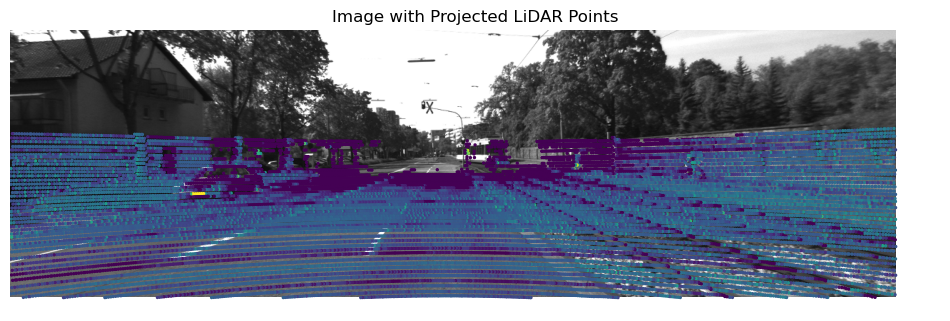

In [ ]:

# calibratiom matrices from the file in repo
R = np.array([[7.533745e-03, -9.999714e-01, -6.166020e-04],
              [1.480249e-02, 7.280733e-04, -9.998902e-01],
              [9.998621e-01, 7.523790e-03, 1.480755e-02]])

T = np.array([-4.069766e-03, -7.631618e-02, -2.717806e-01])


P = np.array([[7.215377e+02, 0, 6.095593e+02, 0],
              [0, 7.215377e+02, 1.728540e+02, 0],
              [0, 0, 1, 0]])

num = 60

if len(image_files) != len(lidar_files):
    print("check ur num of files")
else:

    image_file = image_files[num]
    lidar_file = lidar_files[num]

    image = Image.open(image_file)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    img_width, img_height = image.size

    
    lidar_data = np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)  # [x, y, z, intensity]

    
    lidar_points = lidar_data[:, :3]
    lidar_points_homogeneous = np.hstack((lidar_points, np.ones((lidar_points.shape[0], 1))))  
    transformed_points = lidar_points @ R.T + T


    points_3d_cam = np.hstack((transformed_points, np.ones((transformed_points.shape[0], 1))))  
    points_2d_homogeneous = points_3d_cam @ P.T


    points_2d = points_2d_homogeneous[:, :2] / points_2d_homogeneous[:, 2, None]

    valid_indices = (points_2d_homogeneous[:, 2] > 0) & \
                    (points_2d[:, 0] >= 0) & (points_2d[:, 0] < img_width) & \
                    (points_2d[:, 1] >= 0) & (points_2d[:, 1] < img_height)

    points_2d = points_2d[valid_indices]
    lidar_intensity = lidar_data[valid_indices, 3]  


    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.scatter(points_2d[:, 0], points_2d[:, 1], c=lidar_intensity, s=2, cmap='viridis')
    plt.axis('off')
    plt.title("Image with Projected LiDAR Points")
    plt.show()


In [ ]:
image_path = r"C:\Users\JANAB\Desktop\Research\3D_Reconstruction\KITTI_Dataset\image_00\data"
lidar_path = r"C:\Users\JANAB\Desktop\Research\3D_Reconstruction\KITTI_Dataset\velodyne_points\data"

image_files = sorted(glob.glob(f"{image_path}/*.png"))  
lidar_files = sorted(glob.glob(f"{lidar_path}/*.bin"))

image_file = image_files[0]
lidar_file = lidar_files[0]

lidar_data = np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4) 

pc = o3d.geometry.PointCloud()
pc.points = o3d.utility.Vector3dVector(point_cloud)


o3d.visualization.draw_geometries([pc])
